In [1]:

import sys
from PIL import Image
from pillow_heif import register_heif_opener
import os
import pandas as pd
import cv2
import csv
import random

sys.path.append(r"/home/ammarkeon/Desktop/Image_Project/Code/src/utility.py")
from utility import datacleaner
from utility_38k import dataCleaner_38K

2025-03-12 20:47:52.342761: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 20:47:54.959314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741805276.615704   18939 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741805276.788602   18939 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 20:47:59.141621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Current problems with the dataset
1. **various sizes, need to resize them**
2. **brightness is not formal across dataset**
3. **some images are sharp, need to confirm how much sharpness is acceptable**


## Real Students Dataset

### checking jpg files first


In [2]:
# path to the dataset
RGB_STUDENTS_PATH = "/home/ammarkeon/Desktop/Image_Project/Data/DataSet"
GREY_STUDENTS_PATH = "/home/ammarkeon/Desktop/Image_Project/Data/DataSet_Grey"
MODIFIED_STUDENTS_PATH = "/home/ammarkeon/Desktop/Image_Project/Data/DataSet_modified"

# checking the extension of each picture in the dataset
non_jpg = datacleaner.extention_checker(RGB_STUDENTS_PATH)
for image_path in non_jpg:
    convert_to_jpg(image_path)


100%|██████████| 59/59 [00:00<00:00, 67300.50it/s]

Number of JPG images found: 59
Number of non-JPG images found: 0


# converting images to JPG

In [18]:

def convert_to_jpg(input_path):
    """
    this function takes the path of the image that is **non** JPG and turn it into JPG.
    """
    # this line makes .HEIC file extension able to be converted to JPG
    register_heif_opener()
    # taking the picture from the list of non JPGs
    image_before = Image.open(input_path)

    # converting to the channels to RGB only to be able to convert it to JPG
    converted_to_jpg = image_before.convert("RGB") 
    # Save the image in JPG
    print(input_path)
    converted_to_jpg.save(input_path + "_jpg.jpg")



# creates the CSV file that has labels


In [19]:
import os
import csv
import random

def create_csv(image_folder, output_csv):
    """
    function that takes the path to images and csv file to write in (creates one if it doesnt exist)
        iterates through the entire folder for images in the format (id_number) and uses it to create a csv
    """
    
    # getting all images into a list
    valid_images = []
    for filename in os.listdir(image_folder):
        # split the path
        parts = filename.rsplit('_', 1)  # split only on last '_'
        
        valid_images.append({
            'full_path': filename,
            'id': parts[0],
            'number': parts[1]
        })

    # creates a dictionary that has each unique ID for each student
    # and how many unique pictures they have
    id_of_images = {}
    for img in valid_images:
        id_of_images.setdefault(img['id'], []).append(img)

    pairs = []
    for image1 in valid_images:
        image1_id = image1['id']
        image1_path = image1['full_path']
        
        # get images that have the same id but different number, same image excluded
        positives = [img for img in id_of_images[image1_id]
                    if img['full_path'] != image1_path]
    
        
        # select two random pair that has the same person(id) (max 3)
        selected_positives = random.sample(
            positives, 
            min(3, len(positives))
        )
        num_positives = len(selected_positives)
        
        # certain calculations to minimize negative labels being much more than positive labels
        if num_positives == 1:
            required_negatives = 3
        else: # more than 1 positive pair found, select 4 negatives
            required_negatives = 4
        
        # 
        negative_images = [img for img in valid_images
                              if img['id'] != image1_id]
        
        # selects negatives randomly by having a different id)
        selected_negatives = random.sample(
            negative_images,
            min(required_negatives, len(negative_images))
        ) if negative_images else []

        # generate pairs with labels depending on the id of each image
        for pos in selected_positives:
            pairs.append([image1_path, pos['full_path'], 1])
        for neg in selected_negatives:
            pairs.append([image1_path, neg['full_path'], 0])

    # writing to CSV
    with open(output_csv, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['path1', 'path2', 'label']) 
        writer.writerows(pairs)


create_csv(STUDENTS_PATH, 'students_data.csv')

## reading the CSV


In [6]:
df = pd.read_csv('students_data.csv')
df

,path1,path2,label
0,23101028_1.jpg,23101028_2.jpg,1
1,23101028_1.jpg,23101028_3.jpg,1
2,23101028_1.jpg,23101455_1.jpg,0
3,23101028_1.jpg,23101473_2.jpg,0
4,23101028_1.jpg,23101455_4.jpg,0
...,...,...,...
385,24100428_3.jpg,24100428_2.jpg,1
386,24100428_3.jpg,23101028_2.jpg,0
387,24100428_3.jpg,23102154_3.jpg,0
388,24100428_3.jpg,23101358_3.jpg,0


In [25]:
df.describe

<bound method NDFrame.describe of               path1           path2  label
0    23101028_1.jpg  23101028_3.jpg      1
1    23101028_1.jpg  23101028_2.jpg      1
2    23101028_1.jpg  23101358_3.jpg      0
3    23101028_1.jpg  23101872_2.jpg      0
4    23101028_1.jpg  23101484_3.jpg      0
..              ...             ...    ...
385  24100428_3.jpg  24100428_2.jpg      1
386  24100428_3.jpg  23101379_1.jpg      0
387  24100428_3.jpg  23101551_1.jpg      0
388  24100428_3.jpg  23101467_1.jpg      0
389  24100428_3.jpg  23101358_1.jpg      0

[390 rows x 3 columns]>

In [26]:
value_counts = df['label'].value_counts()

print(f"Value counts for label:")
print(value_counts)

Value counts for label:
label
0    236
1    154
Name: count, dtype: int64


## turning images to Grey Scale


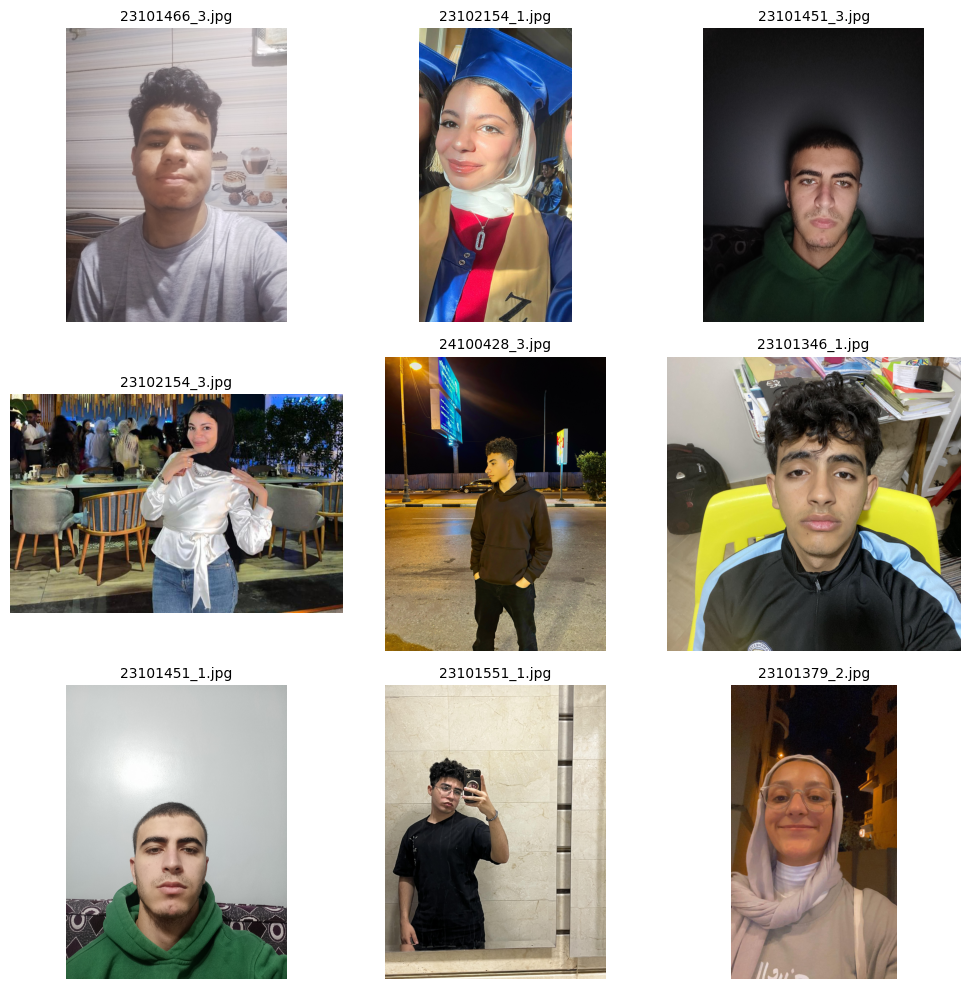

In [ ]:
datacleaner.sample_plot(RGB_STUDENTS_PATH)

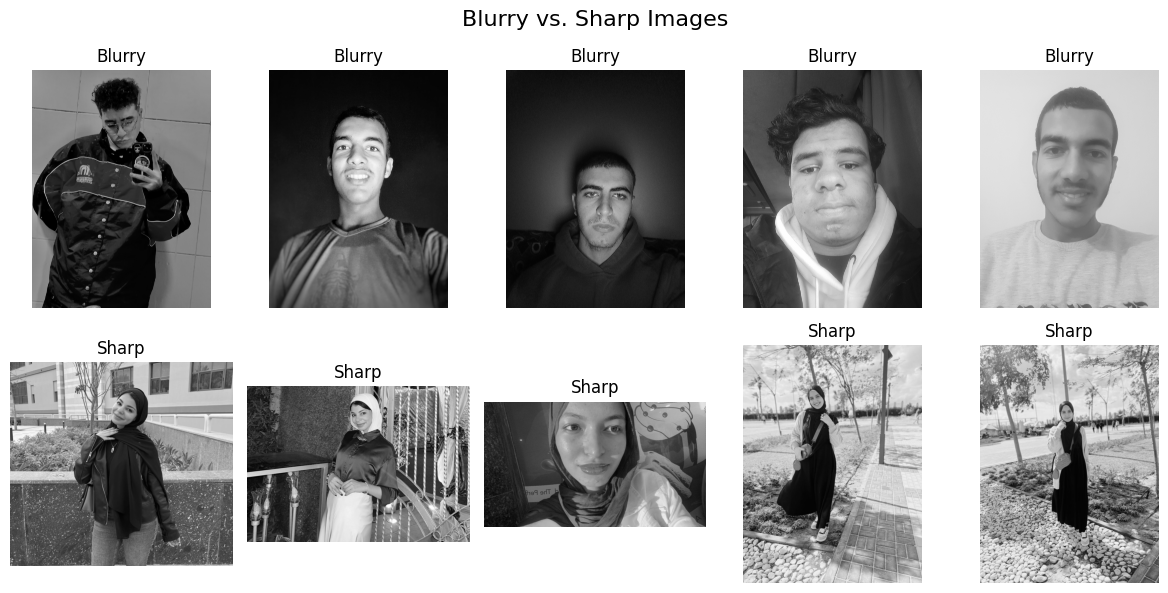

In [16]:
blurry, sharp = datacleaner.check_blur_in_folder(GREY_STUDENTS_PATH)

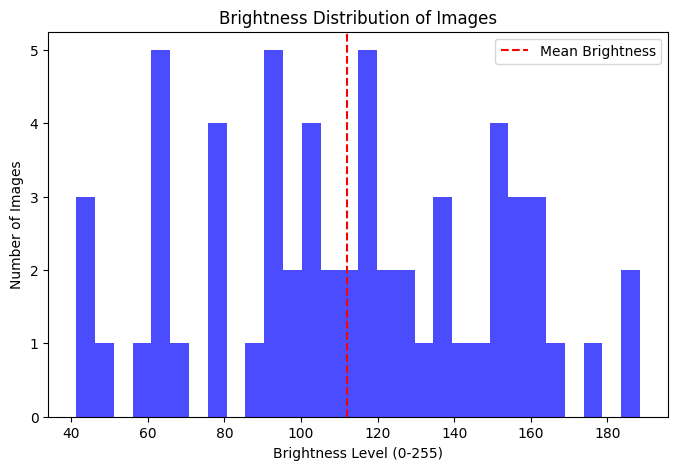

[('24100216_2.jpg', np.float64(41.35264314058957)),
 ('23101451_3.jpg', np.float64(43.385815969710485)),
 ('23101872_2.jpg', np.float64(44.9039137011802)),
 ('23101467_1.jpg', np.float64(50.71289739583333)),
 ('23101467_2.jpg', np.float64(58.3861953125)),
 ('23101358_2.jpg', np.float64(61.71918283483016)),
 ('23101484_2.jpg', np.float64(63.89283586159032)),
 ('23102154_2.jpg', np.float64(63.93903163615255)),
 ('23101455_1.jpg', np.float64(64.31922103332073)),
 ('23101484_1.jpg', np.float64(65.12783191666666)),
 ('23101872_1.jpg', np.float64(70.21741211770033)),
 ('24100428_3.jpg', np.float64(76.4115602790113)),
 ('23101346_3.jpg', np.float64(78.9205198182054)),
 ('23101551_4.jpg', np.float64(80.39263430584425)),
 ('23101455_4.jpg', np.float64(80.57463038745591)),
 ('23102154_4.jpg', np.float64(88.85706728789127)),
 ('23101379_2.jpg', np.float64(90.92082722510267)),
 ('24100216_1.jpg', np.float64(91.39873917196883)),
 ('23101551_2.jpg', np.float64(91.99643321352461)),
 ('23101028_3.jpg'

In [17]:
datacleaner.check_brightness_in_folder(GREY_STUDENTS_PATH)

In [ ]:
from collections import Counter

def check_image_sizes(folder_path):
    sizes = []
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file) # Get the path of each image
        img = cv2.imread(img_path) # Read it
        if img is not None:
            sizes.append(img.shape[:2])  # (Height, Width)

    print("Image size distribution:", Counter(sizes)) # Count number of occerunce of each image size

In [12]:
check_image_sizes(STUDENTS_PATH)

Image size distribution: Counter({(4032, 3024): 9, (1600, 1200): 8, (3088, 2316): 6, (4608, 3456): 6, (1624, 914): 5, (3824, 2868): 2, (4096, 3072): 2, (3264, 1472): 2, (1280, 960): 2, (960, 1280): 1, (1280, 720): 1, (719, 1280): 1, (3024, 3024): 1, (2448, 3264): 1, (3421, 2771): 1, (4000, 3000): 1, (3280, 2460): 1, (1316, 1174): 1, (1200, 623): 1, (1258, 1279): 1, (506, 768): 1, (1214, 1280): 1, (900, 1280): 1, (1174, 1280): 1, (1792, 1008): 1, (1280, 1280): 1, (2282, 1284): 1})


In [ ]:
import os
from PIL import Image

def convert_to_grayscale(input_folder, output_folder):
    """
    Convert all images in the input folder to grayscale and save them to the output folder.

    Parameters:
        input_folder (str): Path to the folder containing the original images.
        output_folder (str): Path to the folder where grayscale images will be saved.
    """

    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        # Check if the file is an image (e.g., .jpg, .png, etc.)
        if filename.lower().endswith(('.jpg')):
            try:
                with Image.open(input_path) as img:
                    # Convert the image to grayscale
                    grayscale_img = img.convert("L")

                    # Construct the output file path
                    output_path = os.path.join(output_folder, filename)

                    # Save the grayscale image
                    grayscale_img.save(output_path)
                    print(f"Converted and saved: {output_path}")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

output_folder = r"A:\Image Project\DataSet_Grey"  # folder to save grey images

convert_to_grayscale(STUDENTS_PATH, output_folder)

Converted and saved: A:\Image Project\DataSet_Grey\23101028_1.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101028_2.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101028_3.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101346_1.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101346_2.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101346_3.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101358_1.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101358_2.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101358_3.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101358_4.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101379_1.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101379_2.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101379_3.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101379_4.jpg
Converted and saved: A:\Image Project\DataSet_Grey\23101379_5.jpg
Converted 

In [23]:
from utility_students import utility_students
utility_students.process_and_overwrite_images(GREY_STUDENTS_PATH, MODIFIED_STUDENTS_PATH)

  0%|          | 0/60 [00:00<?, ?it/s]

NameError: name 'datacleaner' is not defined

## testing mtcnn with camera


In [15]:
from mtcnn import MTCNN
video = cv2.VideoCapture(0)
detector = MTCNN(device='CPU:0')

while True:
    ret, frame = video.read()
    output = detector.detect_faces(frame)
    frame = cv2.resize(frame, (800,600))

    for single_output in output:
        x,y,width,height = single_output['box']
        cv2.rectangle(frame, pt1=(x, y), pt2=(x+width+height, y+height+width), color=(0, 255, 0), thickness=3)
    
    cv2.imshow('win', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('x'):
        break
video.release()
cv2.destroyAllWindows()

In [ ]:
detector = MTCNN()
TARGET_SIZE = (112, 112)   

for img_name in os.listdir(RGB_STUDENTS_PATH):
    img_path = os.path.join(RGB_STUDENTS_PATH, img_name)
   
    image = cv2.imread(img_path)
    
    # convert to RGB for MTCNN
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = detector.detect_faces(rgb_image)
    for i, result in enumerate(results):
        if result['confidence'] > 0.9:  # confidence threshold
            x, y, w, h = result['box']
            
            padding = 0.2 
            x = max(0, int(x - w * padding))
            y = max(0, int(y - h * padding))
            w = int(w * (1 + 2 * padding))
            h = int(h * (1 + 2 * padding))
            
            # saving the face from the image into a variable to modify it
            face = image[y:y+h, x:x+w]
            
            # resizing it to 112 * 112 and using INTER_AREA interpolation to make sure all images are scaled equaly
            resized_face = cv2.resize(face, TARGET_SIZE, interpolation=cv2.INTER_AREA)
            
            # saving cropped face
            base_name = os.path.splitext(img_name)[0]
            output_path = os.path.join(r"/home/ammarkeon/Desktop/Image_Project/Data/DataSet_2ndMod", f"{base_name}.jpg")
            cv2.imwrite(output_path, resized_face)

print("faces have been cropped and saved")

100%|██████████| 59/59 [02:27<00:00,  2.51s/it]


Face cropping completed!
